In [243]:
import os
import sys
import time
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [38]:
warnings.filterwarnings('ignore')

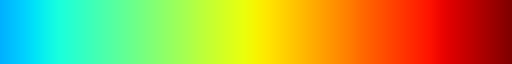

In [39]:
colors2 = plt.cm.jet(np.linspace(0.3, 1, 45))
colors = np.vstack((colors2))
mixedmap = LinearSegmentedColormap.from_list('my_colormap', colors)
mixedmap

In [40]:
BL_dir = Path('/neelin2020/ERA-5_buoy/layer_thetae')
era5_dir = Path('/neelin2020/ERA-5/NC_FILES/2014')
data_temp = xr.open_dataset(BL_dir / 'era5_2layers_thetae_2014_07_15.nc').sel(lat=slice(-30,30))
lon_re = data_temp.lon
lat_re = data_temp.lat

# read file as mfdataset
data_sp = xr.open_dataset(era5_dir / 'era-5.sp.2014.07.nc').sel(latitude=slice(30,-30)).SP/100 # hPa
data_sp = data_sp.reindex(latitude=sorted(list(data_sp.latitude))) # fliping latitude order: -30 to 30
data_sp = data_sp.interp(latitude=lat_re.values, longitude=lon_re.values)
data_sp = data_sp.rename({'latitude': 'lat', 'longitude': 'lon'})

# 3-hourly buoyancy data on the day
files_theta = 'era5_2layers_thetae_2014_07_15.nc'
data = xr.open_dataset(BL_dir / files_theta).sel(lat=slice(-30,30))
sp = data_sp.sel(time=data.time)

thetae_bl = data.thetae_bl
thetae_sat_lt = data.thetae_sat_lt
thetae_lt = data.thetae_lt

delta_pl=sp-100-500 # top at 500hPa
delta_pb=100
wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
wl=1-wb

# calculate buoyancy estimate
Buoy_CAPE = wb * ((thetae_bl-thetae_sat_lt)/thetae_sat_lt) * 340
Buoy_SUBSAT = wl * ((thetae_sat_lt-thetae_lt)/thetae_sat_lt) * 340
Buoy_TOT = Buoy_CAPE - Buoy_SUBSAT # degree Kelvin (K)

In [74]:
# get GPM-IMERG daily mean
dir_gpm = Path('/neelin2020/RGMA_feature_mask/GPM_ncfiles_2014')
files = sorted(list(dir_gpm.glob('GPM_IMERGE_V06_20140715_*.nc')))
data_gpm = xr.open_mfdataset(files)
prec_gpm_daily = data_gpm.precipitationCal.sum('time').sel(lat=slice(-30,30)) # accumulative rainfall
# regrid for clear visualization
prec_gpm_daily_regrid = prec_gpm_daily.interp(lat=np.arange(-30,32.5,2.5), lon=np.arange(-180,180,2.5)).fillna(0)

In [371]:
%%time
# track with MCS initialized during that day
dir_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
data_track = xr.open_dataset(dir_track / 'mcs_tracks_non2mcs_2014.tropics30NS.full.nc')
meanlat = data_track.isel(times=0).meanlat
idx_trop = np.where(abs(meanlat < 30))[0]
data_track = data_track.isel(tracks=idx_trop)

idx_select = []
for track in data_track.tracks:
    data_track_sub = data_track.sel(tracks=track)
    idt_mcs_init = data_track_sub.idt_mcs_init.values
    timestamp = str(data_track_sub.isel(times=idt_mcs_init).base_time.values)
    month = timestamp[5:7]
    day = timestamp[8:10]
    if (month == '07') and (day == '15'):
        idx_select.extend([track])
        
data_track_day = data_track.sel(tracks=idx_select)

# track with deteceted MCS during that day regradless of original initialization time
dir_track = Path('/scratch/wmtsai/temp_mcs/mcs_stats/')
data_track = xr.open_dataset(dir_track / 'mcs_tracks_final_extc_20140101.0000_20150101.0000.nc')
meanlat = data_track.isel(times=0).meanlat
idx_trop = np.where(abs(meanlat < 30))[0]
data_track = data_track.isel(tracks=idx_trop)

idx_select = []
for track in data_track.tracks:
    data_track_sub = data_track.sel(tracks=track)
    timestamp = str(data_track_sub.isel(times=0).base_time.values)
    mcs_status = data_track_sub.isel(times=0).mcs_status.values 
    month = timestamp[5:7]
    day = timestamp[8:10]
    if (month == '07') and (day == '15') :
        idx_select.extend([track])
        
data_track_day_all = data_track.sel(tracks=idx_select)

CPU times: user 2min 54s, sys: 725 ms, total: 2min 55s
Wall time: 2min 56s


In [372]:
# remove non2mcs from those tracks to avoid duplication
idx_diff = np.setdiff1d(data_track_day_all.tracks.values, data_track_day.tracks.values)
data_track_day_all = data_track_day_all.sel(tracks=idx_diff)

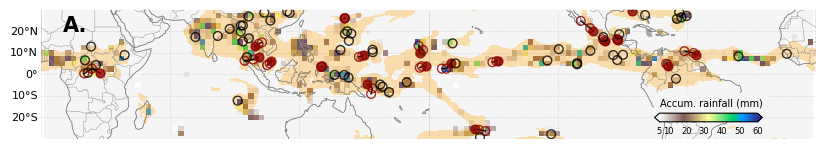

In [446]:
# snapshot at a given day
# plotting tracks on 2014-07-01 and BL

fig, ax = plt.subplots(1,1,figsize=(10,3),subplot_kw={'projection': ccrs.PlateCarree(180)})

ax.coastlines(color='grey',linewidth=0.5)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.spines[:].set_visible(False)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=0.5, color='grey', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8, 'color': 'k'}
gl.ylabel_style = {'size': 8, 'color': 'k'}

# plot daily mean of BL_TOT as background
tmp = Buoy_TOT.mean('time')
tmp = tmp.where(tmp > -5 , 0)
tmp = tmp.where(tmp == 0 , 1)
tmp = tmp.where(tmp == 1) # 1 or nan
cf = ax.pcolormesh(Buoy_TOT.lon, Buoy_TOT.lat, tmp, vmax=1,
          cmap=ListedColormap(["orange"]), transform=ccrs.PlateCarree(), zorder=2, alpha=0.3)

# plot daily accumulative rainfall of GPM-IMERG 
cp = ax.pcolormesh(prec_gpm_daily_regrid.lon, prec_gpm_daily_regrid.lat, prec_gpm_daily_regrid.T,
           cmap='terrain_r', vmin=5, vmax=60, transform=ccrs.PlateCarree())
cp.cmap.set_under('whitesmoke')

# insert colorbar inside the figure
cax = ax.inset_axes([105, -22, 50, 4], transform=ax.transData)
cax.set_facecolor('w')
clabel = [5,10,20,30,40,50,60]
cbar = plt.colorbar(cp, cax=cax, orientation='horizontal', extend='both')
cbar.set_ticks(clabel)
cbar.set_ticklabels(clabel)
cbar.ax.tick_params(labelsize=6, length=0.2)
ax.text(x=107.5, y=-15, s='Accum. rainfall (mm)', fontsize=7, bbox=dict(facecolor='whitesmoke', edgecolor='none'))

# plot dots indicating centroids at different MCS phases
for track in data_track_day.tracks:
    
    data_track_sub = data_track_day.sel(tracks=track)
    
    lon_traject = []
    lat_traject = []    
    time_phases = [data_track_sub.idt_mcs_init, data_track_sub.idt_mcs_mature, data_track_sub.idt_mcs_end]
    for time_sel,color in zip(time_phases,['darkred','none','none']):
        meanlon = data_track_sub.isel(times=time_sel).meanlon
        meanlat = data_track_sub.isel(times=time_sel).meanlat
        lon_traject.extend([meanlon])
        lat_traject.extend([meanlat])
        ax.scatter(meanlon, meanlat, marker='o', s=40, color='darkred', facecolors=color,alpha=0.8, transform=ccrs.PlateCarree(), zorder=3)
    
    ax.plot(lon_traject, lat_traject, color='k',alpha=1, transform=ccrs.PlateCarree(), lw=1, zorder=2) # show line only

# plot dots indicating centroids at different MCS phases
for track in data_track_day_all.tracks:
    
    data_track_sub = data_track_day_all.sel(tracks=track)    
    meanlon = data_track_sub.isel(times=0).meanlon
    meanlat = data_track_sub.isel(times=0).meanlat
    ax.scatter(meanlon, meanlat, marker='o', s=40, color='k', facecolors=color,alpha=0.8, transform=ccrs.PlateCarree(), zorder=3)

#geo_extent = [50, 180, -30, 30]
#ax.set_extent(geo_extent)
ax.set_ylim([-30,30])   
ax.text(x=-170, y=20, s='A.', fontsize=15, fontweight='bold',
       bbox=dict(facecolor='none', alpha=0.7, edgecolor='none', pad=2.5, lw=0.5))
plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/Fig1_globalmap_exampleday.pdf',
  bbox_inches='tight', transparent=False)


#### B. Fraction of time exceeding -5K and MCS frequency

In [154]:
def buoy_calc(year, month):

    # 1. 0.25-deg, 3-hourly buoyancy measure: BL = BL,cape - BL,subsat
    buoy_files = list(buoy_dir.glob('era5_2layers_thetae_{}_{}_*.nc'.format(year,str(month).zfill(2))))
    data_buoy = xr.open_mfdataset(buoy_files).sel(lat=slice(-30,30))

    data_sp = xr.open_dataset(era5_dir / 'era-5.sp.{}.{}.nc'.format(year,str(month).zfill(2))).sel(latitude=slice(30
    ,-30)).SP/100 # hPa
    data_sp = data_sp.reindex(latitude=sorted(list(data_sp.latitude))) # fliping latitude order: -30 to 30
    data_sp = data_sp.interp(latitude=data_buoy.lat.values, longitude=data_buoy.lon.values)
    data_sp = data_sp.rename({'latitude': 'lat', 'longitude': 'lon'})
    sp = data_sp.sel(time=data_buoy.time)

    thetae_bl = data_buoy.thetae_bl
    thetae_sat_lt = data_buoy.thetae_sat_lt
    thetae_lt = data_buoy.thetae_lt

    delta_pl=sp-100-500 # top at 500hPa
    delta_pb=100
    wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
    wl=1-wb

    Buoy_CAPE = wb * ((thetae_bl-thetae_sat_lt)/thetae_sat_lt) * 340
    Buoy_SUBSAT = wl * ((thetae_sat_lt-thetae_lt)/thetae_sat_lt) * 340
    Buoy_TOT = Buoy_CAPE - Buoy_SUBSAT # degree Kelvin (K)

    return Buoy_TOT

In [213]:
%%time
year = 2002
buoycri_dir = Path('/scratch/wmtsai/temp_mcs/output_stats')
mask_dir = Path('/neelin2020/mcs_flextrkr/{}'.format(year))
buoy_dir = Path('/neelin2020/ERA-5_buoy/layer_thetae/')
era5_dir = Path('/neelin2020/ERA-5/NC_FILES/{}'.format(year))

ds_month_list = []
for month in range(1,3):
    # calculate buoyancy measure
    ds_buoy = buoy_calc(year, month)
    # get 3-hourly MCS mask on the coordinated grids with buoy in a specific month
    mcscounts_if5K = np.zeros((ds_buoy.shape[1], ds_buoy.shape[2]))
    buoycounts_if5K = np.copy(mcscounts_if5K)

    total_time = 0
    for time_sel in ds_buoy.time.values:

        year = str(time_sel)[:4]
        month = str(time_sel)[5:7]
        day = str(time_sel)[8:10]
        hour = str(time_sel)[11:13]

        try:
        
            ds_mcs = xr.open_dataset(mask_dir / 'mcstrack_{}{}{}_{}30.nc'.format(year,month,day,hour))
            buoy = ds_buoy.sel(time=time_sel)
            buoy_binary = buoy.where(buoy > -5, 0)
            buoy_binary = buoy_binary.where(buoy_binary == 0 ,1)
        
            # regrid flextrkr MCS mask
            cldmask = ds_mcs.cloudtracknumber_nomergesplit.isel(time=0).sel(lat=slice(-30,30))
            cldmask['lon'] = cldmask.lon.where(cldmask.lon > 0, cldmask.lon + 360)
            cldmask= cldmask.reindex(lon = sorted(cldmask.lon))
            cldmask_regrid = cldmask.interp(lon = ds_buoy.lon, lat = ds_buoy.lat)
            cldmask_regrid = cldmask_regrid.where(cldmask_regrid > 0, 0) 
            cldmask_regrid = cldmask_regrid.where(cldmask_regrid == 0 ,1)
            
            # counts when local BL > -5K 
            mcscounts_if5K += cldmask_regrid.where(buoy_binary == 1, 0).values
            buoycounts_if5K += buoy_binary.values
            total_time += 1

        except:

            print('failed date: {}'.format(str(time_sel)[:13]))
    
    ds_month = xr.Dataset(data_vars=dict(mcscounts_if5K=(['lat','lon'], mcscounts_if5K),
                                        buoycounts_if5K=(['lat','lon'], buoycounts_if5K),
                                        ),
                        coords=dict(lat=(['lat'], buoy.lat.values),
                                    lon=(['lon'], buoy.lon.values),
                                    total_time = total_time),
                        attrs=dict(description = 'counts when BL > -5K. 3-hrly MCS mask that matches 3-hourly BL data.'))
    ds_month_list.append(ds_month)

# merge all months 
ds_month_merged = xr.concat(ds_month_list, pd.Index(np.arange(1,3),name='month'))


CPU times: user 58.8 s, sys: 14.1 s, total: 1min 12s
Wall time: 1min 12s


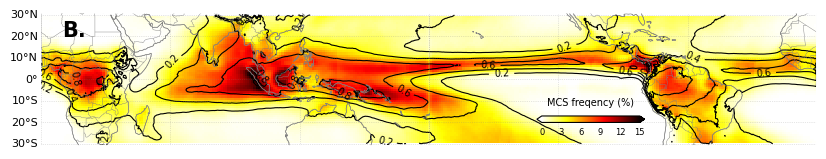

In [462]:
tmp_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/MCSbouy_counts_n5K/')
files = sorted(list(tmp_dir.glob('MCSbuoy_counts_*')))
file_list = []
for file in files:
    file_list.append(xr.open_dataset(file))
ds_merged = xr.concat(file_list, pd.Index(np.arange(len(files)), name='year'))
mcscounts_if5K = ds_merged.mcscounts_if5K
buoycounts_if5K = ds_merged.buoycounts_if5K
mcscounts_if5K_clim = mcscounts_if5K.sum(('month')).mean('year') # annual local counts 
buoy_frac_clim = (buoycounts_if5K/ds_merged.total_time).mean(('month','year')) # mean fraction of times with BL > -5K

ds_uc = xr.open_dataset('/scratch/wmtsai/temp_mcs/output_stats/MCScount_geomap/MCScount_total_2001.2020.nc')
mcscounts_uc = ds_uc.counts/20/(24*365) # total freq. by hourly data
mcscounts_uc['lon'] = mcscounts_uc.lon.where(mcscounts_uc.lon > 0, mcscounts_uc.lon + 360)
mcscounts_uc = mcscounts_uc.reindex(lon = sorted(mcscounts_uc.lon))
mcscounts_uc = mcscounts_uc.interp(lat=np.arange(-30,31,1),lon=np.arange(0,360,1)).fillna(0)

fig, ax = plt.subplots(1,1,figsize=(10,3),subplot_kw={'projection': ccrs.PlateCarree(180)})

ax.coastlines(color='grey',linewidth=0.5)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.spines[:].set_visible(False)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=0.5, color='grey', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8, 'color': 'k'}
gl.ylabel_style = {'size': 8, 'color': 'k'}

# plot contourf and colormesh
cp = ax.pcolormesh(mcscounts_uc.lon, mcscounts_uc.lat, 100*mcscounts_uc, vmin=0, vmax=15,
                   cmap='hot_r', transform=ccrs.PlateCarree())
cf = ax.contour(buoy_frac_clim.lon, buoy_frac_clim.lat, buoy_frac_clim, levels=[0.2,0.4,0.6,0.8], 
                colors= ['k'], alpah=0.7, linewidths=0.8, transform=ccrs.PlateCarree())
cf.clabel([0.2,0.4,0.6,0.8], fontsize=7)
# insert colorbar inside the figure
cax = ax.inset_axes([50, -20, 50, 3], transform=ax.transData)
cax.set_facecolor('w')
clabel = [0,3,6,9,12,15]
cbar = plt.colorbar(cp, cax=cax, orientation='horizontal', extend='both')
cbar.set_ticks(clabel)
cbar.set_ticklabels(clabel)
cbar.ax.tick_params(labelsize=6, length=0.2)
ax.text(x=54.5, y=-12, s='MCS freqency (%)', fontsize=7, bbox=dict(facecolor='none', edgecolor='none'))

ax.set_xlim([-180,179.5])
ax.text(x=-170, y=20, s='B.', fontsize=15, fontweight='bold',
       bbox=dict(facecolor='none', alpha=0.7, edgecolor='none', pad=2.5, lw=0.5))
plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/Fig1_MCSfreq_BLfractime.pdf',
            bbox_inches='tight', transparent=False)

In [415]:
# MCS number initialized only
stats_dir = Path('/scratch/wmtsai/temp_mcs/mcs_stats/mcs_tracks_non2mcs')
ds_stats = xr.open_dataset(stats_dir / 'mcs_tracks_non2mcs_2011.tropics30NS.full.nc')
mask_dir = Path('/neelin2020/mcs_flextrkr/2011/')

counts_init_map = np.zeros((241,1440)) # 0.25-deg 30S-30N
for track in ds_stats.tracks.values:

    ds_track = ds_stats.sel(tracks=track)
    idt_mcs_init = ds_track.idt_mcs_init # initialized time for MCS status
    timestamp = ds_track.isel(times=idt_mcs_init).base_time.values
    year = str(timestamp)[:4]
    month = str(timestamp)[5:7]
    day = str(timestamp)[8:10]
    hour = str(timestamp)[11:13]
    # get corrresponding map of cloud mask
    ds_mask = xr.open_dataset(mask_dir / 'mcstrack_{}{}{}_{}30.nc'.format(year,month,day,hour))
    cldmask = ds_mask.cloudtracknumber_nomergesplit.sel(lat=slice(-30,30)).isel(time=0)
    cldmask['lon'] = cldmask.lon.where(cldmask.lon > 0, cldmask.lon + 360)
    cldmask = cldmask.reindex(lon = sorted(cldmask.lon))
    cldmask_sel = cldmask.where(cldmask == track+1, 0)
    # regridding on the ERA-5 coordinates
    cldmask_regrid = cldmask_sel.interp(lon=np.arange(0,360,0.25),lat=np.arange(-30,30.25,0.25)).fillna(0) 
    cldmask_regrid = cldmask_regrid.where(cldmask_regrid == 0, 1)
    counts_init_map += cldmask_regrid.values

In [473]:
tmp = counts_init_map

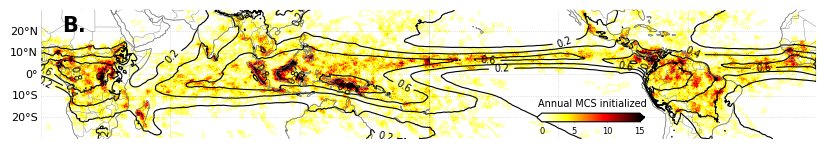

In [474]:
tmp_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/MCSbouy_counts_n5K/')
files = sorted(list(tmp_dir.glob('MCSbuoy_counts_*')))
file_list = []
for file in files:
    file_list.append(xr.open_dataset(file))
ds_merged = xr.concat(file_list, pd.Index(np.arange(len(files)), name='year'))
mcscounts_if5K = ds_merged.mcscounts_if5K
buoycounts_if5K = ds_merged.buoycounts_if5K
mcscounts_if5K_clim = mcscounts_if5K.sum(('month')).mean('year').fillna(0) # annual local counts 
buoy_frac_clim = (buoycounts_if5K/ds_merged.total_time).mean(('month','year')) # mean fraction of times with BL > -5K

fig, ax = plt.subplots(1,1,figsize=(10,3),subplot_kw={'projection': ccrs.PlateCarree(180)})

ax.coastlines(color='grey',linewidth=0.5)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.spines[:].set_visible(False)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=0.5, color='grey', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8, 'color': 'k'}
gl.ylabel_style = {'size': 8, 'color': 'k'}

# plot contourf and colormesh
cp = ax.pcolormesh(mcscounts_if5K_clim.lon, mcscounts_if5K_clim.lat, tmp[:-1,:], vmin=0, vmax=15,
                   cmap='hot_r', transform=ccrs.PlateCarree())
cf = ax.contour(buoy_frac_clim.lon, buoy_frac_clim.lat, buoy_frac_clim, levels=[0.2,0.4,0.6,0.8], 
                colors= ['k'], alpah=0.7, linewidths=0.8, transform=ccrs.PlateCarree())
cf.clabel([0.2,0.4,0.6,0.8], fontsize=7)
# insert colorbar inside the figure
cax = ax.inset_axes([50, -22, 50, 4], transform=ax.transData)
cax.set_facecolor('w')
clabel = [0,5,10,15]
cbar = plt.colorbar(cp, cax=cax, orientation='horizontal', extend='both')
cbar.set_ticks(clabel)
cbar.set_ticklabels(clabel)
cbar.ax.tick_params(labelsize=6, length=0.2)
ax.text(x=50.5, y=-15, s='Annual MCS initialized', fontsize=7, bbox=dict(facecolor='none', edgecolor='none'))

ax.set_xlim([-180,179.5])
ax.text(x=-170, y=20, s='B.', fontsize=15, fontweight='bold',
       bbox=dict(facecolor='none', alpha=0.7, edgecolor='none', pad=2.5, lw=0.5))
plt.show()
fig.savefig('/scratch/wmtsai/temp_mcs/fig/Fig1_initialMCScounts_BLfractimes.png',dpi=600,
            bbox_inches='tight', transparent=False)

515096.0